# ResNet

In [ ]:
# model.py (paper-faithful ResNet v1 core)

from typing import List, Type # Optional -> Type으로 바꿔서 클래스 자체를
import torch
import torch.nn as nn


# shortcut의 3가지 옵션
## 논문에서 option A, B, C 이야기를 하는데 So we do not use option C in the rest of this paper.라고 명시함
###  (A) zero-padding shortcuts are used for increasing dimensions, and all shortcuts are parameterfree (the same as Table 2 and Fig. 4 right); 
###  (B) projection shortcuts are used for increasing dimensions, and other shortcuts are identity
###  (C) all shortcuts are projections. 이지만 논문에서 C는 사용하지 않으므로 구현하지 않음

### 숏컷으로 연결할 때 채널이 맞지 않을 때 -> zero-pad or linear projection
# CIFAR 실험에서 사용된 차원 증가용 제로 패딩 숏컷 ( option A )
class ShortcutZeroPad(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        if out_channels < in_channels:
            raise ValueError(
                "ShortcutZeroPad only supports channel increase (out_channels >= in_channels). "
                "Use projection shortcut (1x1 conv) for channel decrease."
            )
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.stride = stride


        # shortcut도 같은 해상도로 맞춰야 더하기가 가능하다.
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1) 공간 해상도(H,W) 맞추기
        # main path에서 stride=2로 다운샘플링하면 F(x)의 H,W가 절반으로 줄어든다.
        if self.stride != 1:
            x = x[:, :, ::self.stride, ::self.stride]
        # 2) 채널(C) 맞추기 (zero-padding)
        # main path의 out_channels가 더 크면 shortcut도 채널 수를 맞춰야 한다.
        # Option A는 부족한 채널 수만큼 "0으로 채워진 채널"을 뒤에 붙인다.
        pad_channels = self.out_channels - self.in_channels

        # 채널 변화가 없으면 그대로 반환
        if pad_channels == 0:
            return x

        # x와 같은 device/dtype으로 0 텐서를 만들어 채널 방향(dim=1)에 붙인다.
        zeros = torch.zeros(
            (x.size(0), pad_channels, x.size(2), x.size(3)),
            device=x.device,
            dtype=x.dtype,
        )
        # 결과 shape: [N, out_channels, H, W]
        return torch.cat([x, zeros], dim=1)

# Projection 숏컷 (1x1 컨볼루션) ( option B ) -> 표준으로 사용되는 방식
class ShortcutProjection(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, stride: int):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride) #conv 1x1
        self.bn = nn.BatchNorm2d(out_channels)

    def forward(self, x: torch.Tensor):
        return self.bn(self.conv(x))
    
# Figure 2. Residual learning: a building block. 부분
class BasicBlockV1(nn.Module):
    expansion = 1 # BasicBlock에서는 채널 수 변화 없음
    # in_channels: 입력 채널 수, out_channels: 출력 채널 수, stride: 스트라이드, shortcut: option A vs B
    def __init__(self, in_channels: int, out_channels: int, stride: int, shortcut: str = "projection"):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        # shape이 같으면 연산 X (항등 매핑)
        if stride == 1 and in_channels == out_channels:
            self.shortcut = nn.Identity()
        # shape이 다르면 projection(option B) or zero_pad(option A)에 따라 숏컷 구성
        else:
            if shortcut == "projection":
                self.shortcut = ShortcutProjection(in_channels, out_channels, stride=stride)
            elif shortcut == "zero_pad":
                self.shortcut = ShortcutZeroPad(in_channels, out_channels, stride=stride)
            else:
                raise ValueError(f"Unknown shortcut mode: {shortcut}")
    # 딱 Fiqure 2 그림 그자체
    def forward(self, x: torch.Tensor):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = out + identity ### 숏컷 연결!
        out = self.relu(out)
        return out

# fiqure 5의 우측 Bottleneck design 부분
class BottleneckV1(nn.Module):
    expansion = 4  # 출력 채널을 4배로 늘림 논문 table 1 참조
    # in_channels: 입력 채널 수, planes: 내부 채널 수, stride: 스트라이드, shortcut: option A vs B
    def __init__(self, in_channels: int, planes: int, stride: int, shortcut: str = "projection"):
        super().__init__()
        # 4배 늘어난 출력 채널 수
        out_channels = planes * self.expansion

        # conv1x1 -> conv3x3 -> conv1x1 순서
        # padding X -> map 크기 줄어듦
        self.conv1 = nn.Conv2d(in_channels, planes, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        # 여기서 stride 적용
        # padding O -> map 크기 유지
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        # out channel * 4 -> 크기 커짐
        self.conv3 = nn.Conv2d(planes, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        self.relu = nn.ReLU(inplace=True)
        # shape이 같으면 연산 X (항등 매핑)
        if stride == 1 and in_channels == out_channels:
            self.shortcut = nn.Identity()
        # shape이 다르면 projection(option B) or zero_pad(option A)에 따라 숏컷 구성
        else:
            if shortcut == "projection":
                self.shortcut = ShortcutProjection(in_channels, out_channels, stride=stride)
            elif shortcut == "zero_pad":
                self.shortcut = ShortcutZeroPad(in_channels, out_channels, stride=stride)
            else:
                raise ValueError(f"Unknown shortcut mode: {shortcut}")
    # fiqure 5의 우측 Bottleneck design 부분 (위 내용 참조)
    def forward(self, x: torch.Tensor):
        identity = self.shortcut(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + identity
        out = self.relu(out)
        return out

# ResNet 전체 구조
class ResNetV1(nn.Module):
    def __init__(
        self,
        block: Type[nn.Module],
        layers: List[int],
        num_classes: int,
        stem: str,  #imagenet or cifar
        shortcut: str, # option A or B
        cifar_base_channels: int = 16,
    ):
        super().__init__()
        self.shortcut = shortcut

        # stem 부분 구성 (논문 Figure 3 참조)
        # imagenet용과 cifar용 구분 (논문 Section 4.2 참조)
        if stem == "imagenet":
            self.in_channels = 64
            self.stem = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False),
                nn.BatchNorm2d(64),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            )
            stage_planes = [64, 128, 256, 512]
        elif stem == "cifar":
            self.in_channels = cifar_base_channels
            self.stem = nn.Sequential(
                nn.Conv2d(3, cifar_base_channels, kernel_size=3, stride=1, padding=1, bias=False),
                nn.BatchNorm2d(cifar_base_channels),
                nn.ReLU(inplace=True),
            )
            stage_planes = [16, 32, 64]
        else:
            raise ValueError("stem must be 'imagenet' or 'cifar'")

        # stage 구성: 첫 block은 stride=2 (layer1 제외)
        self.layer1 = self._make_layer(block, stage_planes[0], layers[0], stride=1)
        self.layer2 = self._make_layer(block, stage_planes[1], layers[1], stride=2)
        self.layer3 = self._make_layer(block, stage_planes[2], layers[2], stride=2)

        if stem == "imagenet":
            self.layer4 = self._make_layer(block, stage_planes[3], layers[3], stride=2)
            final_ch = stage_planes[3] * getattr(block, "expansion", 1)
        else:
            self.layer4 = None
            final_ch = stage_planes[2] * getattr(block, "expansion", 1)
        # 분류기 부분 구성 avgpool + fc
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(final_ch, num_classes)

    # stage 구성 함수 (논문 Figure 3 참조) 
    def _make_layer(self, block: Type[nn.Module], planes: int, blocks: int, stride: int) -> nn.Sequential:
        layers = []
        expansion = getattr(block, "expansion", 1)
        # 첫 번째 블록은 stride 적용
        # BottleneckV1인 경우
        if block is BottleneckV1:
            layers.append(block(self.in_channels, planes, stride=stride, shortcut=self.shortcut))
            self.in_channels = planes * expansion
            # 두 번째 블록부터는 stride=1 고정
            for _ in range(1, blocks):
                layers.append(block(self.in_channels, planes, stride=1, shortcut=self.shortcut))
        # BasicBlockV1인 경우
        else:
            out_channels = planes * expansion
            layers.append(block(self.in_channels, out_channels, stride=stride, shortcut=self.shortcut))
            self.in_channels = out_channels
            # 두 번째 블록부터는 stride=1 고정
            for _ in range(1, blocks):
                layers.append(block(self.in_channels, out_channels, stride=1, shortcut=self.shortcut))

        return nn.Sequential(*layers)

    # forward 함수: ResNet 전체 구조 구현 (논문 Figure 3 참조)
    def forward(self, x: torch.Tensor):
        x = self.stem(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        # imagenet용일 때만 layer4 적용
        if self.layer4 is not None:
            x = self.layer4(x)
        # 최종 분류기 부분 (AdaptiveAvgPool + FC) 
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.fc(x)

# MNIST 돌려보기 컨퓨전 매트릭스, 로스펑션 그래프 그리기
# ResNet 모델 생성 함수 (imagenet 용)
def resnet_imagenet(depth: int, num_classes: int = 1000, shortcut: str = "projection"):
    if depth == 18:
        return ResNetV1(BasicBlockV1, [2, 2, 2, 2], num_classes, stem="imagenet", shortcut=shortcut)
    if depth == 34:
        return ResNetV1(BasicBlockV1, [3, 4, 6, 3], num_classes, stem="imagenet", shortcut=shortcut)
    if depth == 50:
        return ResNetV1(BottleneckV1, [3, 4, 6, 3], num_classes, stem="imagenet", shortcut=shortcut)
    if depth == 101:
        return ResNetV1(BottleneckV1, [3, 4, 23, 3], num_classes, stem="imagenet", shortcut=shortcut)
    if depth == 152:
        return ResNetV1(BottleneckV1, [3, 8, 36, 3], num_classes, stem="imagenet", shortcut=shortcut)
    raise ValueError("Unsupported depth")

# ResNet 모델 생성 함수 CIFAR-10용
def resnet_cifar(depth: int, num_classes: int = 10, shortcut: str = "zero_pad"):
    # paper CIFAR: depth = 6n + 2
    if (depth - 2) % 6 != 0:
        raise ValueError("CIFAR depth must be 6n+2")
    n = (depth - 2) // 6
    return ResNetV1(BasicBlockV1, [n, n, n], num_classes, stem="cifar", shortcut=shortcut)


# RNN, LSTM

[[2.53065030e-01 2.45070970e-01 2.33983036e-01 4.66075110e-04
  2.32039560e-01]
 [2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.78314566e-01 1.98470380e-01 5.70171193e-01
  1.78104644e-01]] -> [0.16053716]
[[2.29604366e-01 2.39728936e-01 2.54567513e-01 2.98467330e-03
  2.37426028e-01]
 [2.49235510e-01 2.41668371e-01 2.48338489e-01 2.59926504e-04
  2.26793794e-01]
 [2.21013495e-01 2.46602231e-01 2.54710584e-01 0.00000000e+00
  2.62668239e-01]
 [3.63433786e-01 3.70389871e-01 2.67168847e-01 1.24764722e-02
  2.62105010e-01]
 [2.59447633e-01 3.10673724e-01 2.74113889e-01 4.56323384e-01
  2.71751265e-01]
 [2.76008150e-01 2.7831

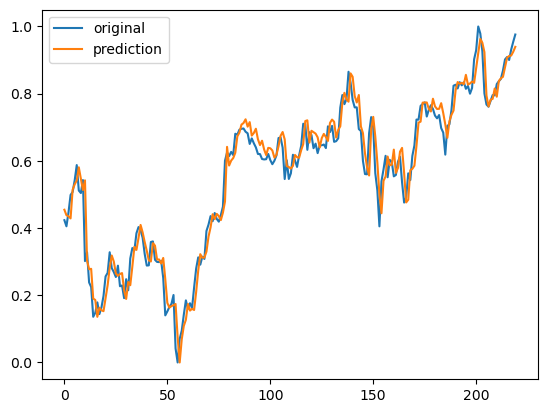

In [ ]:
# RNN

import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Random seed to make results deterministic and reproducible
torch.manual_seed(0)

# scaling function for input data
def minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    return numerator / (denominator + 1e-7)

# make dataset to train

def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

# hyper parameters
seq_length = 7
data_dim = 5
# hidden_vector -> 이전의 정보를 이용해 다음 정보를 예측
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

# load data
xy = np.loadtxt("data-02-stock_daily.csv", delimiter=",")
xy = xy[::-1]  # reverse order

# split train-test set
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]

# scaling data
train_set = minmax_scaler(train_set)
test_set = minmax_scaler(test_set)

# make train-test dataset to input
trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# convert to tensor
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        # 입력 게이트: 새로운 정보를 얼마나 받아들일지
        # 망각 게이트: 기존의 정보를 얼마나 유지할지
        # 출력 게이트: 현재 셀의 상태를 얼마나 외부로 출력할지
        self.fc = torch.nn.Linear(hidden_dim, output_dim, bias=True)

    def forward(self, x):
        x, _status = self.rnn(x)
        x = self.fc(x[:, -1])
        return x

net = Net(data_dim, hidden_dim, output_dim, 1)

# loss & optimizer setting
criterion = torch.nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=learning_rate)

# start training
for i in range(iterations):

    optimizer.zero_grad()
    outputs = net(trainX_tensor)
    loss = criterion(outputs, trainY_tensor)
    loss.backward()
    optimizer.step()
    print(i, loss.item())

plt.plot(testY)
plt.plot(net(testX_tensor).data.numpy())
plt.legend(['original', 'prediction'])
plt.show()